In [312]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm import tqdm 
from scipy.stats import norm
from scipy.stats import qmc

np.warnings.filterwarnings("ignore")
plt.style.use('Solarize_Light2')

In [276]:
# Sampling methods
# @jit(nopython=True)
def random_sampling(x_range, y_range, density, seed=42):
    """
    Uses np.random.random to generate PRNGs: https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html
    Returns randomly sampled points within a given range
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns: 
        random_c  Array with sampled complex numbers
    """
    np.random.seed(seed)

    X = (x_range[1]-x_range[0])*np.random.random(density) + x_range[0]
    Y = (y_range[1]-y_range[0])*np.random.random(density) + y_range[0]
    random_complex = X + Y * 1j
    
    return random_complex

# @jit(nopython=True)
def latin_and_ortho(x_range, y_range, density, ortho=False, seed=42):
    """
    Latin hypercube sampling in 2 dimensions, with optional possibility for orthogonal sampling.
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns:
        random_c    Array with sampled complex numbers
    """

    if not ortho:
        sampler = qmc.LatinHypercube(d=2, seed=seed)
    
    else:
        sampler = qmc.LatinHypercube(d=2, strength=2, seed=seed)

    sample = sampler.random(n=density)

    # Rearranging the bounds for LHC scaling
    l_bounds = np.asarray([x_range[0], y_range[0]])
    u_bounds = np.asarray([x_range[1], y_range[1]])

    sample = qmc.scale(sample, l_bounds, u_bounds)
    samples = np.asarray(sample)

    re = samples[:, 0]
    im = samples[:, 1]

    random_c = re + im * 1j

    return random_c

# Auxilliary functions
def primesfrom2to(n):
    """ 
    Since orthogonal sampling only works with samplesizes that are square primes, a prime number generator is added.
    Args
        n>=6    upper limit for sequence of primes

    Returns 
                array of primes, 2 <= p < n 
    """
    sieve = np.ones(n//3 + (n%6==2), dtype=bool)
    for i in range(1,int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[       k*k//3     ::2*k] = False
            sieve[k*(k-2*(i&1)+4)//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0][1:]+1)|1)]

In [277]:
# Rejection Sampling
@jit(nopython=True)
def rejection_sampling(x_range, y_range, C, max_iterations=150):
    """
    Estimates the area of the mandelbrot set by keeping bounded values
    and discarding diverging values.

    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
    Returns:
        Area        Area estimation
    """

    Z = np.zeros_like(C)
    T = np.zeros(C.shape)

    for i in range(max_iterations):
        M = Z.real ** 2 + Z.imag ** 2 <= 2

        Z[M] = Z[M] ** 2 + C[M]

        T[M] = i + 1

        # sub_total = np.count_nonzero(T)
        # sub_area = (sub_total/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    total = np.count_nonzero(T == max_iterations)
    area = (total/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    return area, M

In [278]:
# Testing the sampling methods
x_range = [-2., 0.5]
y_range = [-1.5, 1.5]

sample_size =  10201 # HERE
max_iterations = 100

# Sampling points
random_sample = random_sampling(x_range, y_range, density=sample_size)
latin_sample = latin_and_ortho(x_range, y_range, density=sample_size)
ortho_sample = latin_and_ortho(x_range, y_range, density=sample_size, ortho=True)

# Area estimation
random_area, M_random = rejection_sampling(x_range, y_range, random_sample)
latin_area, M_latin = rejection_sampling(x_range, y_range, latin_sample)
ortho_area, M_ortho = rejection_sampling(x_range, y_range, ortho_sample)

Ms = [M_random, M_latin, M_ortho]

# print(counted_area[0])
print(f'First estimation of area through random sampling: {random_area}')
print(f'First estimation of area through LHS sampling: {latin_area}')
print(f'First estimation of area through orthogonal sampling: {ortho_area}')

First estimation of area through random sampling: 1.5160278404078031
First estimation of area through LHS sampling: 1.5263209489265759
First estimation of area through orthogonal sampling: 1.5314675031859621


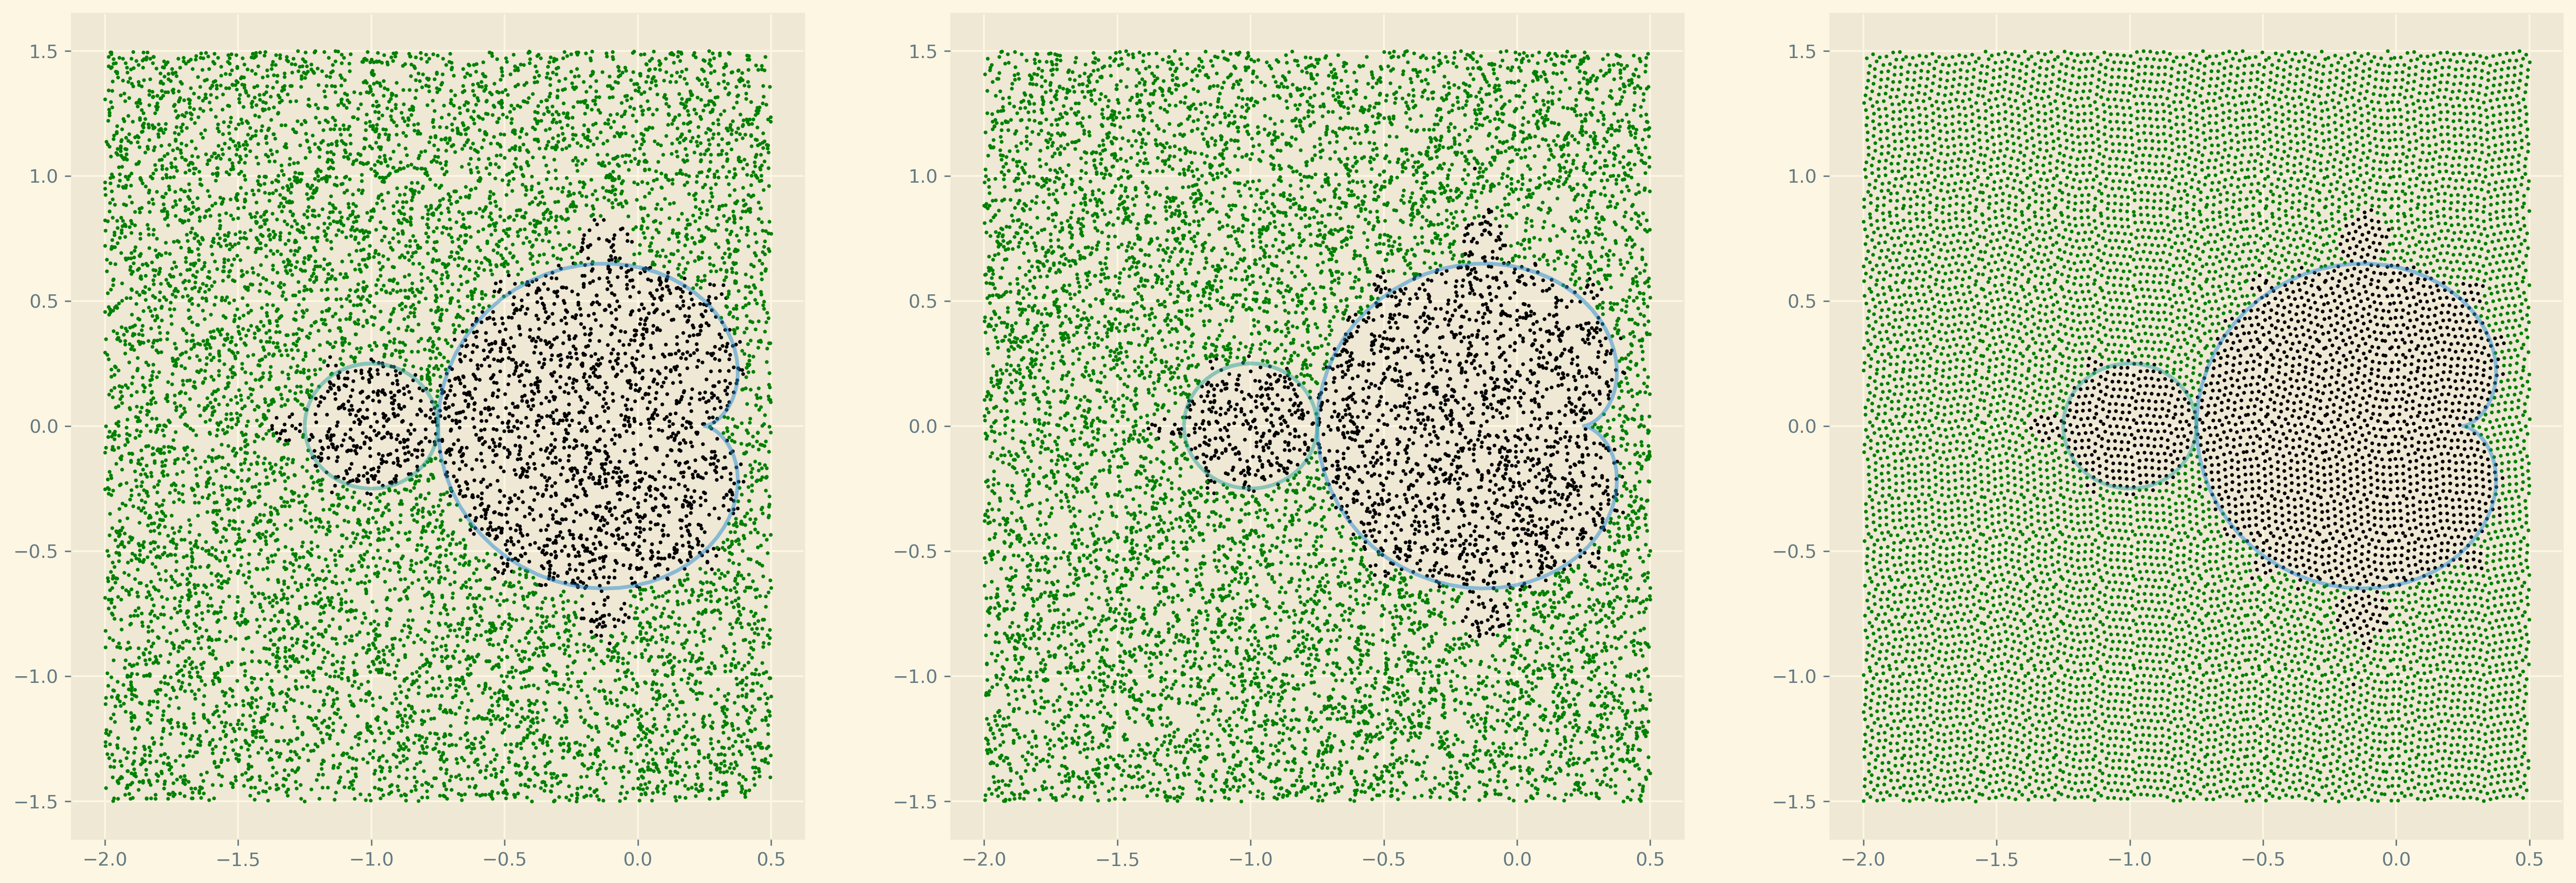

In [279]:
# PLotting
def cardioid(t):
    """
    Parametric equations for cardioid (orbital 1 pts) to be plotted on top of mandelbrot set
    """
    x = 0.5 * np.cos(t) - 0.25 * np.cos(2*t)
    y = 0.5 * np.sin(t) - 0.25 * np.sin(2*t)

    return x, y

def circle(t,r):
    """
    Parametric equations for circle (orbital 2 pts) to be plotted on top of mandelbrot set
    """
    x = r  * np.cos(t) - 1
    y = r * np.sin(t) 

    return x, y

t = np.linspace(-5, 2, 100)
radius = 0.25

re,im = cardioid(t)
re_c, im_c = circle(t, radius)

fig, ax = plt.subplots(1,3, figsize=(24,8), dpi = 300)
for i, type in enumerate([random_sample, latin_sample, ortho_sample]):
    ax[i].plot([z.real for z in type[Ms[i]]], [z.imag for z in type[Ms[i]]], 'ko', markersize =1)
    ax[i].plot([z.real for z in type[~Ms[i]]], [z.imag for z in type[~Ms[i]]], 'go', markersize =1)
    ax[i].plot(re, im, alpha=0.5)
    ax[i].plot(re_c, im_c,alpha=0.5)



# Convergence Rate

s is the number of samples used for the area estimation, while i is the iteration count.

In [280]:
@jit(nopython=True)
def iteration_conv(x_range, y_range, C, max_iter_count=150):
    """
    Estimates the area of the mandelbrot using a range of iteration values.

    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
    Returns:
        Area        Area estimation
    """

    Areas = np.zeros(max_iter_count)

    for i in range(1, max_iter_count):
        area, Ms = rejection_sampling(x_range, y_range, C, max_iterations=i)
        Areas[i] = area
    
    return Areas

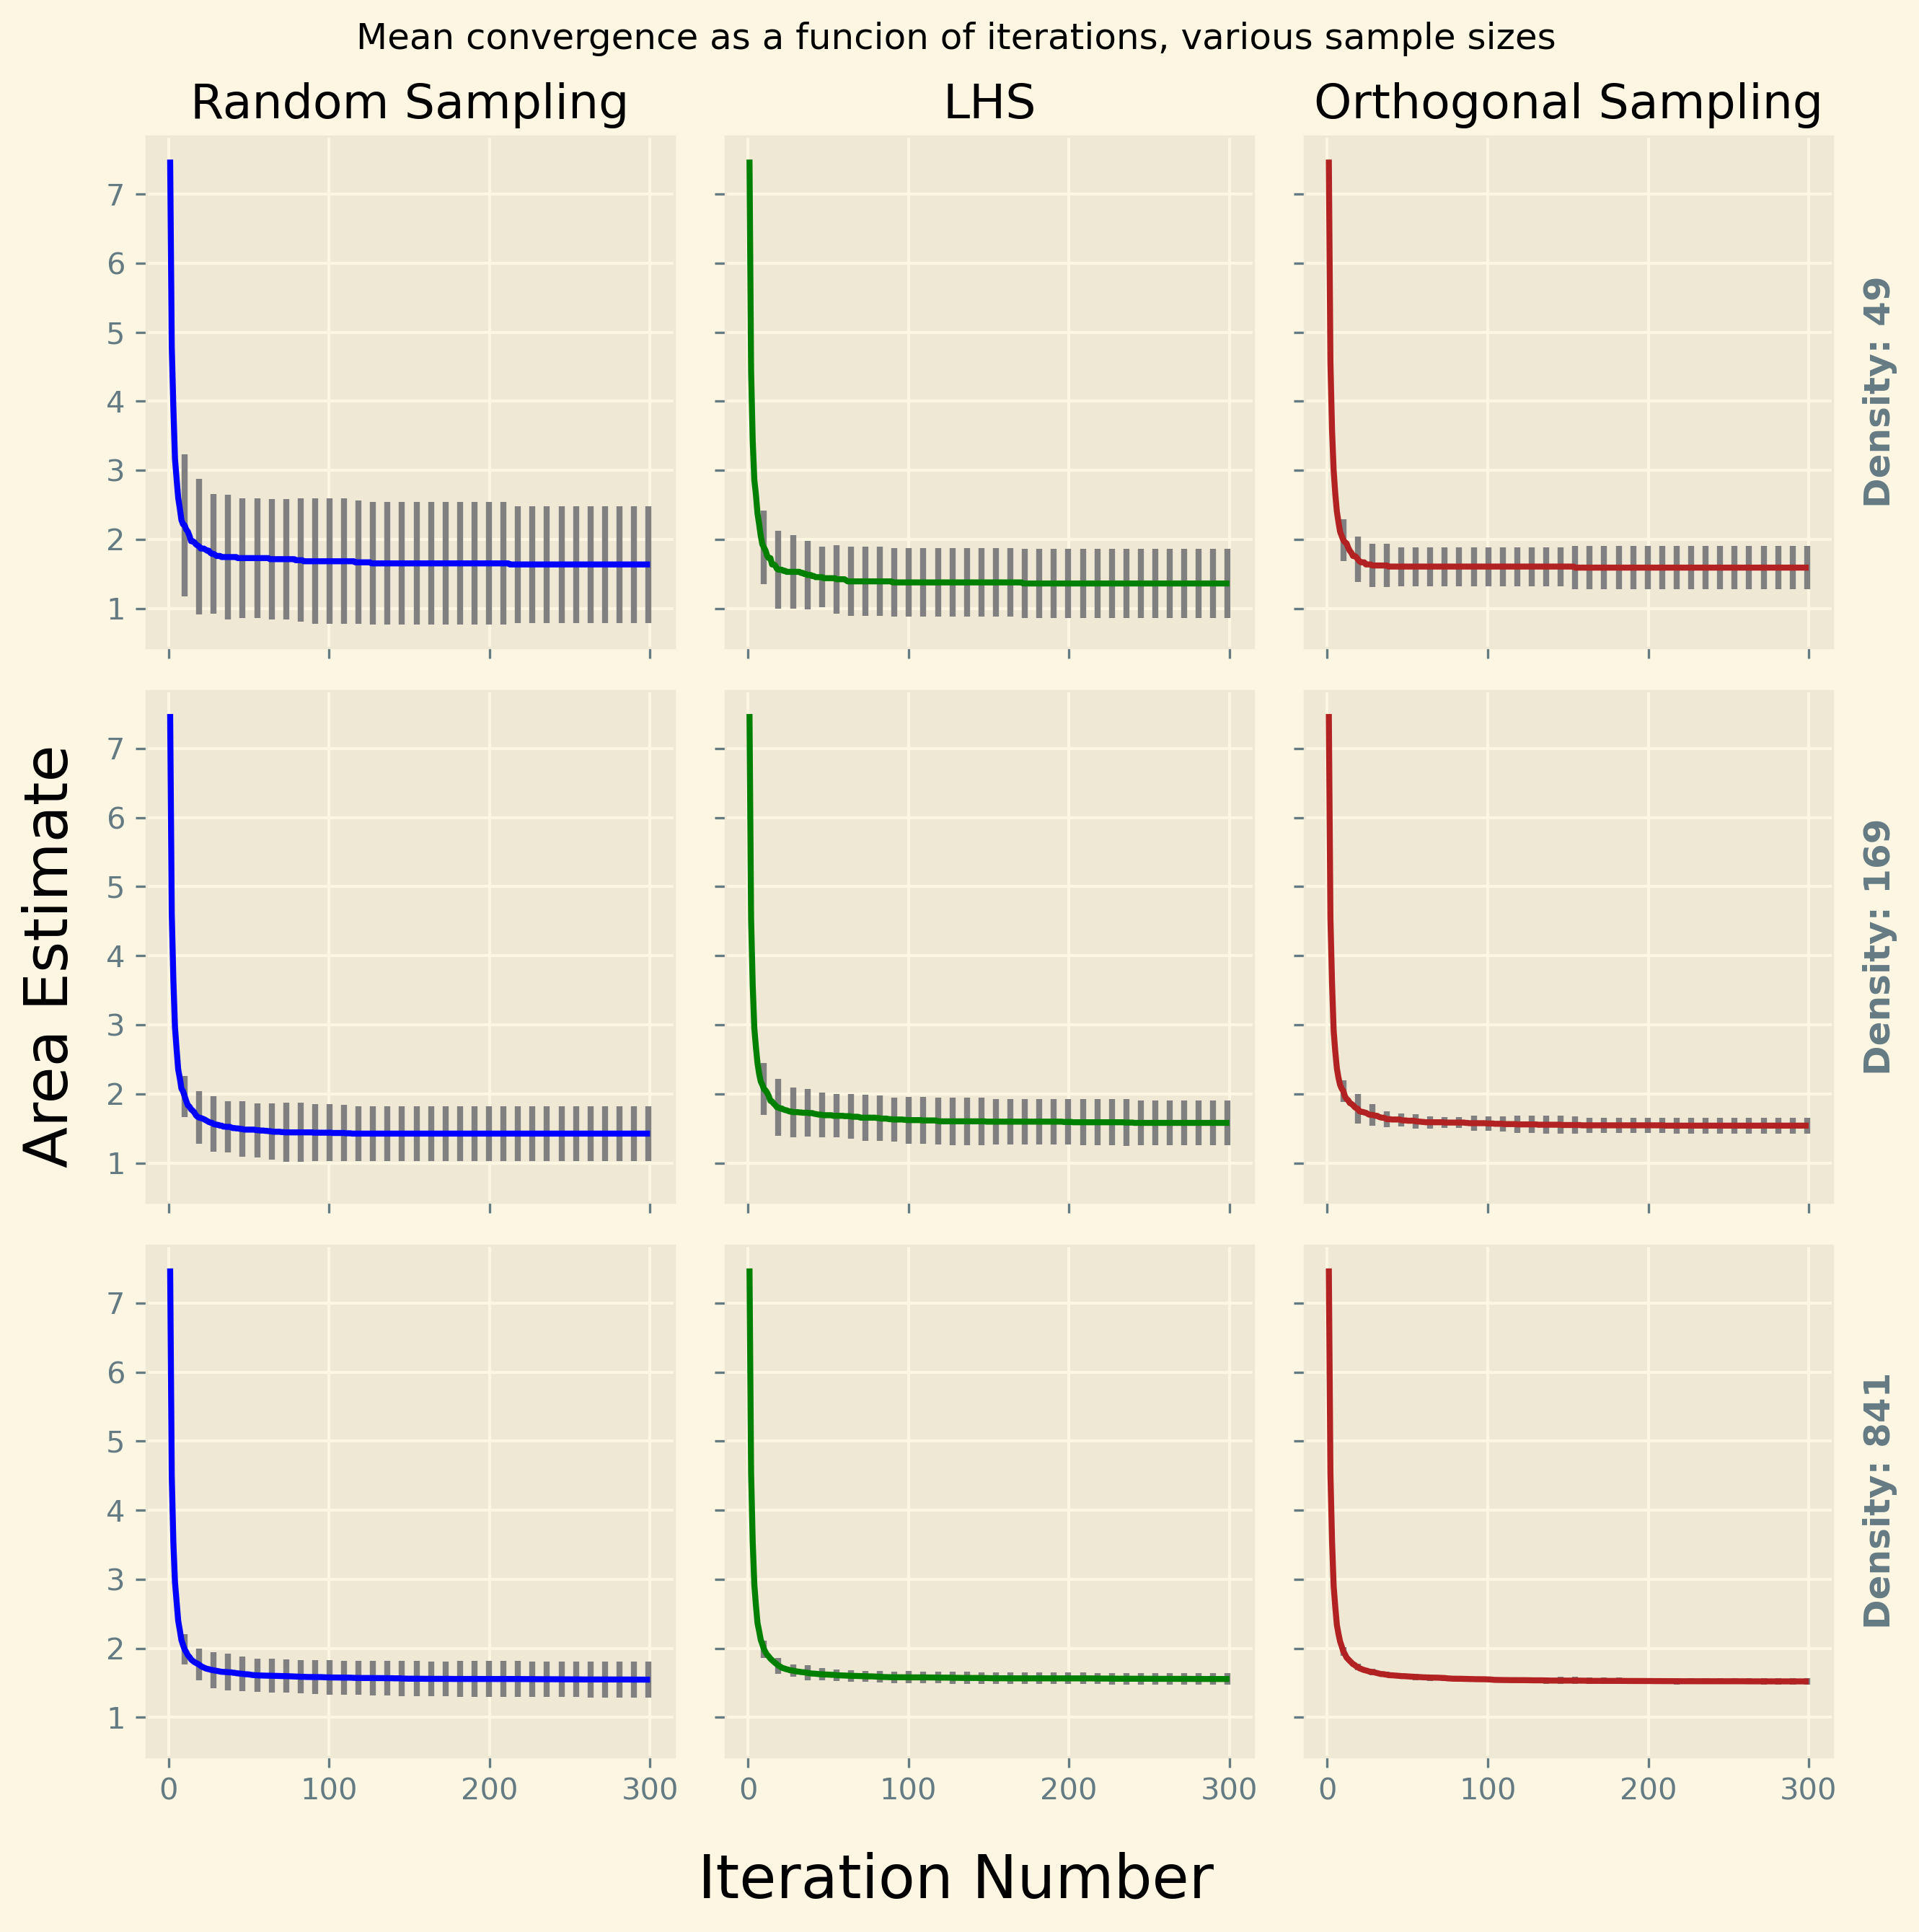

In [299]:
# Testing the functions
# HERE
N_i = 300 # Number of iterations
x_i = np.linspace(1,N_i,N_i-1)
num_repeats = 10

square_primes = primesfrom2to(30)**2
sample_sizes = [square_primes[3], square_primes[5], square_primes[len(square_primes)-1]]
sample_types = [random_sample, latin_sample, ortho_sample]

fig, ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(9,9), dpi=300)
for s in range(3):# for each density we wish to sample at
    rand_areas = np.zeros(num_repeats*N_i)
    all_rands = np.array_split(rand_areas,num_repeats)

    lhs_areas = np.zeros(num_repeats*N_i)
    all_latin = np.array_split(lhs_areas,num_repeats)

    ortho_areas = np.zeros(num_repeats*N_i)
    all_ortho = np.array_split(ortho_areas,num_repeats)

    latin_means = np.zeros(N_i)
    ortho_means = np.zeros(N_i)
    for r in range(num_repeats): # for repeat measurements
        random_sample = random_sampling(x_range, y_range, density=sample_sizes[s], seed=r+1)
        latin_sample = latin_and_ortho(x_range, y_range, density=sample_sizes[s],seed=r+1)
        ortho_sample = latin_and_ortho(x_range, y_range, density=sample_sizes[s],seed=r, ortho=True)

        all_rands[r] = iteration_conv(x_range, y_range, random_sample, max_iter_count=N_i)
        all_latin[r] = iteration_conv(x_range, y_range, latin_sample, max_iter_count=N_i)
        all_ortho[r] = iteration_conv(x_range, y_range, ortho_sample, max_iter_count=N_i)

    means = [np.mean(all_rands, axis=0), # calculating means for all iteration values and all sampling types
                  np.mean(all_latin, axis=0),
                  np.mean(all_ortho, axis = 0)]


    stds = [np.std(all_rands, axis=0), # calculating STDs for all iteration values and all sampling types
            np.std(all_latin, axis=0),
            np.std(all_ortho, axis=0)]

    # PLOTTING
    converged_area = [areas[-1] for areas in means]
    colors = ['blue', 'green', 'firebrick']

    sampling_labels = ['Random Sampling', 'LHS', 'Orthogonal Sampling']
    fig.axes[s+2+2*s].set_ylabel(f'Density: {sample_sizes[s]}', rotation=90, weight='bold', fontsize=12, labelpad=10)
    fig.axes[s+2+2*s].yaxis.set_label_position('right')

    ax[0,s].set_title(f'{sampling_labels[s]}')

    for i, type in enumerate(means):
        relative_errors = [np.abs(area - converged_area[i]) for area in type]
        ax[s,i].errorbar(x_i, type[1:], yerr=2*stds[i][1:], errorevery=9,color=colors[i], ecolor='grey')


fig.suptitle('Mean convergence as a funcion of iterations, various sample sizes')
fig.supxlabel('Iteration Number', fontsize=20)
fig.supylabel('Area Estimate', fontsize=20)
plt.tight_layout()
plt.show()
        


# Varying Sample Size
Next, we generate various densities for our respective sampling methods. We must adhere to using the squares of prime numbers as a density value, since the orthogonal sampling method has this as a constraint.

In [300]:
def density_conv(x_range,y_range,num_repeats,multi_dens=False,density_range=1,density_value=841):
    """
    Calculates the mean value, as well as its standard deviation, as a function of sample size(=density).
    Args
        x_range         range of the real component
        y_range         range of the imaginary component
        num_repeats     number of repeat measurements
        density_range   determines number of sample sizes to be evaluated
    Returns
        mean_Areas      Mean across repeat measurements, for all sample types
        std_Areas       STD across repeat measurements, for all sample types
        density_values  Density values that were sampled

    """
    if multi_dens==True:
        primes = primesfrom2to(density_range)
        density_values = primes**2

        no_densities = len(primes)
    else:
        density_values = [density_value]
        no_densities = 1

    rep_Areas = np.zeros((no_densities, 3)) # Areas for all sampling types at various densities, with repeated sampling for statistics

    for n in range(num_repeats):
        seed = n
        Areas = np.zeros((no_densities, 3)) # Areas for all 3 sampling types at various densities

        for s, density in enumerate(density_values):
            random_sample = random_sampling(x_range, y_range, density, seed=seed)
            latin_sample= latin_and_ortho(x_range, y_range, density, seed=seed)
            ortho_sample = latin_and_ortho(x_range, y_range, density, ortho=True, seed=seed)
            for t, sample in enumerate([random_sample, latin_sample, ortho_sample]):
                Areas[s, t], M = rejection_sampling(x_range, y_range, sample, max_iterations=100)

        if not rep_Areas.any():
            rep_Areas = Areas
        else:
            rep_Areas = np.vstack((rep_Areas, Areas))

    ### Mean
    mean_Areas = np.zeros((no_densities,3))

    indeces = np.full(num_repeats, no_densities) # array of length num_repeats, filled with the number of densities
    indeces = indeces * range(len(indeces)) # multiply by K*density count, with K = 0,1,2...num_repeats

    for i in indeces:
        for j in range(no_densities):
            mean_Areas[j] = mean_Areas[j] +  rep_Areas[j+i]

    mean_Areas = mean_Areas * 1/num_repeats

    ### Standard Deviation
    std_Areas = np.zeros((no_densities, 3))

    if multi_dens==True:
        compl_Arr = np.array_split(rep_Areas, num_repeats)
    else:
        compl_Arr = [rep_Areas]

    for t in range(3):
        density_stds = np.zeros(no_densities) # An array holding each density
        for i in range(no_densities):
            std_list = np.zeros(num_repeats)# create list for each density which contains all area measurements across the repeats
            for rep_num, sub_arr in enumerate(compl_Arr):
                area = sub_arr[i, t]
                std_list[rep_num] = area
            std = np.std(std_list)
            density_stds[i] = std

        std_Areas[:, t] = density_stds
    
    return mean_Areas, std_Areas, density_values

N_s = 100 # HERE
num_repeats = 50
max_iter = 100

means_density_conv, std_density_conv, density_values = density_conv(x_range,y_range,num_repeats,multi_dens=True,density_range=N_s,density_value=841)

# Saving Arrays in case of crash
file_means2 = "Data/MEANs_samplesize_convergence_" + str(N_s) + str(max_iter) + ".npy"
file_stds2 = "Data/STDs_samplesize_convergence_" + str(N_s) + str(max_iter) + ".npy"

np.save(file_means2, means_density_conv)
np.save(file_stds2, std_density_conv)

## Uncomment this section if GitHub Repo data should be loaded
# means_density_conv = np.load("Data/MEANs_samplesize_convergence_" + str(N_s) + str(max_iter) + ".npy")
# std_density_conv = np.load("Data/STDs_samplesize_convergence_" + str(N_s) + str(max_iter) + ".npy")

[1.5477309  1.54577001 1.54419173]


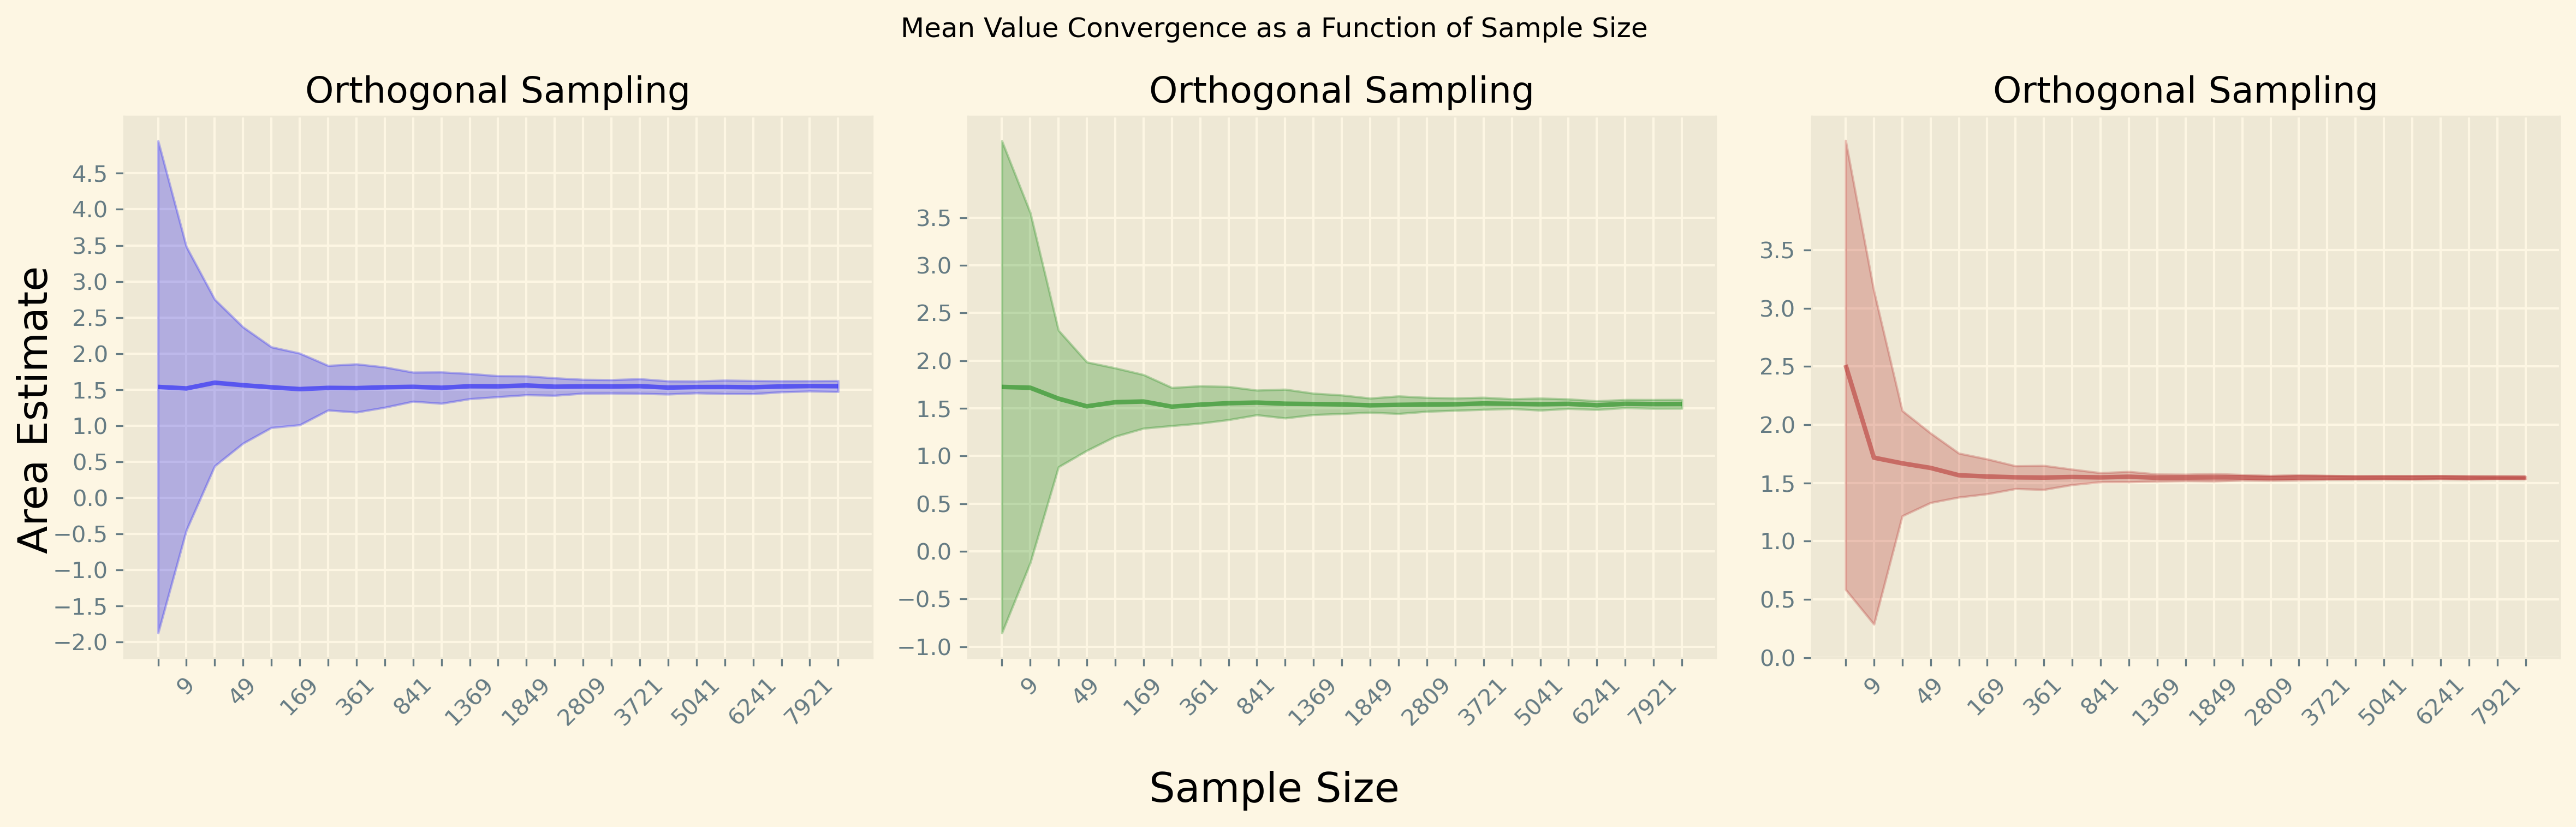

In [301]:
# PLOTTING
x = [str(val) for val in density_values]

colors = ['blue', 'green', 'firebrick']

fig = plt.figure(figsize=(16,5), dpi=300)
for i in range(3):
    plt.subplot(131+i)
    upper = means_density_conv[:, i] + 2*std_density_conv[:, i]
    lower = means_density_conv[:, i] - 2*std_density_conv[:, i]
    plt.plot(x, means_density_conv[:, i], alpha=0.5, color=colors[i])
    plt.fill_between(x, lower, upper,alpha=0.25,color=colors[i])

    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 45)

    start, end = [int(lim) for lim in ax.get_ylim()] # alternatively, plt.ylim
    ax.yaxis.set_ticks(np.arange(start, end, 0.5)) # alternatively, plt.yticks(np.arange...)
    title = ax.set_title(sampling_labels[t], loc='center')

    # Setting every second x_tick invisible
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

print(means_density_conv[-1])

fig.suptitle('Mean Value Convergence as a Function of Sample Size')
fig.supxlabel('Sample Size', fontsize=18)
fig.supylabel('Area Estimate',fontsize=18)
plt.tight_layout()
plt.show()

# Confidence Interval

In [ ]:
def sample_size_intervals(i,s,min_reps,max_reps):
    """
    Determining the required number of measurements in order to achieve a certain
    confidence level, for a given confidence interval of size d
    Args:
        i           iteration number
        s           sample size (number of sample points)
        d           size of confidence interval
        max_reps    maximum number of samples
    Returns
        CIs         Size of confidence intervals as a function of Sample Size
    """
    min_reps = min_reps
    max_reps = max_reps
    rep_range = max_reps - min_reps
    # Array holding means and STDs for various run counts
    sample_means = np.zeros((rep_range,3))
    sample_stds = np.zeros((rep_range,3))

    for m in range(min_reps,rep_range):
        means, stds, density_values = density_conv(x_range,y_range,num_repeats=m,multi_dens=False,density_range=N_s,density_value=s)
        for t in range(3):
            sample_means[m,t] = means[:,t]
            sample_stds[m,t] = stds[:,t]

    CIs = np.zeros((3,rep_range))
    rep_index = [r+1 for r in range(min_reps, max_reps)]

    for type in range(3):
        for rep_num, mean in enumerate(sample_means):
            
            CI_l, CI_u = norm.interval(alpha=0.95,loc=mean[type], scale=sample_stds[rep_num,type])
            CI = CI_u - CI_l
            CIs[type,rep_num] = CI

    return CIs, rep_index


CIs, reps = sample_size_intervals(50, 10201,min_reps=10,max_reps=150)

# Saving Arrays in case of crash
file_CIs = "Data/CIs.npy"

np.save(file_CIs, CIs)

## Uncomment this section if GitHub Repo data should be loaded
# CIs = np.load("Data/CIs.npy")

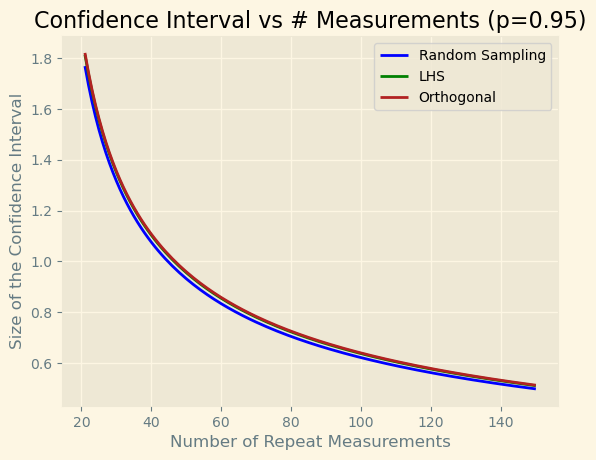

In [ ]:
print(CIs[-1])

# PLOTTING
types = ['Random Sampling', 'LHS', 'Orthogonal']
colors = ['blue', 'green', 'firebrick']

for t,CI_type in enumerate(CIs):
    plt.plot(reps,CI_type,label=types[t],color=colors[t])
plt.title("Confidence Interval vs # Measurements (p=0.95)")
plt.xlabel("Number of Repeat Measurements")
plt.ylabel("Size of the Confidence Interval")
plt.legend()

# Control Variates
In order to reduce variance, we find another random variable Y that satisfies $Cov(X,Y) \neq 0$, allowing us to reduce overall variance

In [ ]:
# Setting Y as our control variate, which we define as the estimation of the area of the circle centered at (-1, 0) with radius 0.25
def control_variate_area(x_range, y_range, C):
    """
    Estimates the area of the circle corresponding to orbital = 2.
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        C           sample points for the accept-reject method
    Returns:
        Area        Area estimation of the circle corresponding to orbital = 2
    """

    # Creating a Boolean Mask for Control Variate
    center_x = -1
    center_y = 0
    radius = 0.25

    mask = (C.real - center_x)**2 + (C.imag - center_y)**2 <= radius**2

    array = np.zeros(C.shape)
    array[mask] = 1

    total_control = np.count_nonzero(array)
    area_Y = (total_control/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    return area_Y

In [ ]:
control_random_area = control_variate_area(x_range, y_range, random_sample)
control_latin_area = control_variate_area(x_range, y_range, latin_sample)
control_ortho_area = control_variate_area(x_range, y_range, ortho_sample)

In [ ]:
print(control_random_area, control_latin_area, control_ortho_area)

0.1694411414982164 0.25862068965517243 0.2140309155766944


In [313]:
def transform_area(x_range, y_range,density,num_reps, max_iter):
    """
    Creates an unbiased estimator by transforming the original area estimate using a control variate
    Args
        x_range     range of the real component
        y_range     range of the imaginary component
    """
    primes = primesfrom2to(density)
    density_values = primes**2

    no_densities = len(primes)

    mu_y = np.pi * 0.25**2 # expected value of our control variate

    rep_Areas = np.zeros((no_densities, 3)) # Areas for all sampling types at various densities, with repeated sampling for statistics
    contr_rep_Areas = np.zeros((no_densities, 3))

    for n in range(num_reps):
        seed = n
        Areas = np.zeros((no_densities, 3)) # Areas for all 3 sampling types at various densities
        contr_Areas = np.zeros((no_densities,3)) # Areas for control variate for all 3 sampling types, various densities

        for s, density in enumerate(density_values):
            random_sample = random_sampling(x_range, y_range, density, seed=seed) # samples for the RV (=Area of Mandelbrot)
            latin_sample= latin_and_ortho(x_range, y_range, density, seed=seed)
            ortho_sample = latin_and_ortho(x_range, y_range, density, ortho=True, seed=seed)

            # c_r_sample = random_sampling([-1.5,-0.5], [-0.5,0.5], density, seed=seed+42) # samples for the control variate [-1.5,-0.5], [-0.5,0.5]
            # c_l_sample = latin_and_ortho([-1.5,-0.5], [-0.5,0.5], density, seed=seed+42)
            # c_o_sample = latin_and_ortho([-1.5,-0.5], [-0.5,0.5], density, ortho=True,seed=seed+42)
            # control_sample_list = [c_r_sample, c_l_sample, c_o_sample]
            
            for t, sample in enumerate([random_sample, latin_sample, ortho_sample]):
                Areas[s, t], M = rejection_sampling(x_range, y_range, sample, max_iterations=max_iter)
                contr_Areas[s,t] = control_variate_area(x_range, y_range, sample)
        if not rep_Areas.any():
            rep_Areas = Areas
            contr_rep_Areas = contr_Areas
        else:
            rep_Areas = np.vstack((rep_Areas, Areas))
            contr_rep_Areas = np.vstack((contr_rep_Areas, contr_Areas))


    split_Arr = np.array_split(rep_Areas, num_reps)
    split_contr = np.array_split(contr_rep_Areas, num_reps)

    mean_arr = np.zeros((no_densities, 9)) # Array to hold all means for area, control variate and transformed x, for all sample types
    std_arr = np.zeros((no_densities, 9)) # same for STD

    for t in range(3):
        for n in tqdm(range(len(density_values))):
            X = np.zeros(num_reps)
            Y = np.zeros(num_reps)
            for r in range(num_reps):
                X[r] = split_Arr[r][n][t]
                Y[r] = split_contr[r][n][t]
            
            S = np.cov(X,Y) # Covariance matrix for Original Area and Control Variate
            cov_xy = S[0,1]
            var_y = S[1,1]

            c_opti = -((cov_xy) / var_y)

            transformed_X = X + c_opti * (Y - mu_y)

            mean_X = np.mean(X)
            mean_Y = np.mean(Y)
            mean_trans = np.mean(transformed_X)

            mean_arr[n,0+3*t] = mean_X
            mean_arr[n, 1+3*t] = mean_Y
            mean_arr[n, 2+3*t] = mean_trans

            std_X = np.std(X)
            std_Y = np.std(Y)
            std_trans = np.std(transformed_X)

            std_arr[n,0+3*t] = std_X
            std_arr[n, 1+3*t] = std_Y
            std_arr[n, 2+3*t] = std_trans
        
            if n%4 == 0:
                # Saving Arrays in case of crash
                file_means3 = "Data/MEANs_Control_Variate_" + str(N_s) + str(num_repeats) + ".npy"
                file_stds3 = "Data/STDs_Control_Variate_" + str(N_s) + str(num_repeats) + ".npy"

                np.save(file_means3, mean_arr)
                np.save(file_stds3, std_arr)
        
        
    return mean_arr, std_arr, no_densities, density_values

100%|██████████| 30/30 [00:00<00:00, 5185.19it/s]


[1.51925366 0.19722375 1.51876852 1.51862519 0.19744694 1.51818987
 1.51861931 0.19628397 1.51861138]


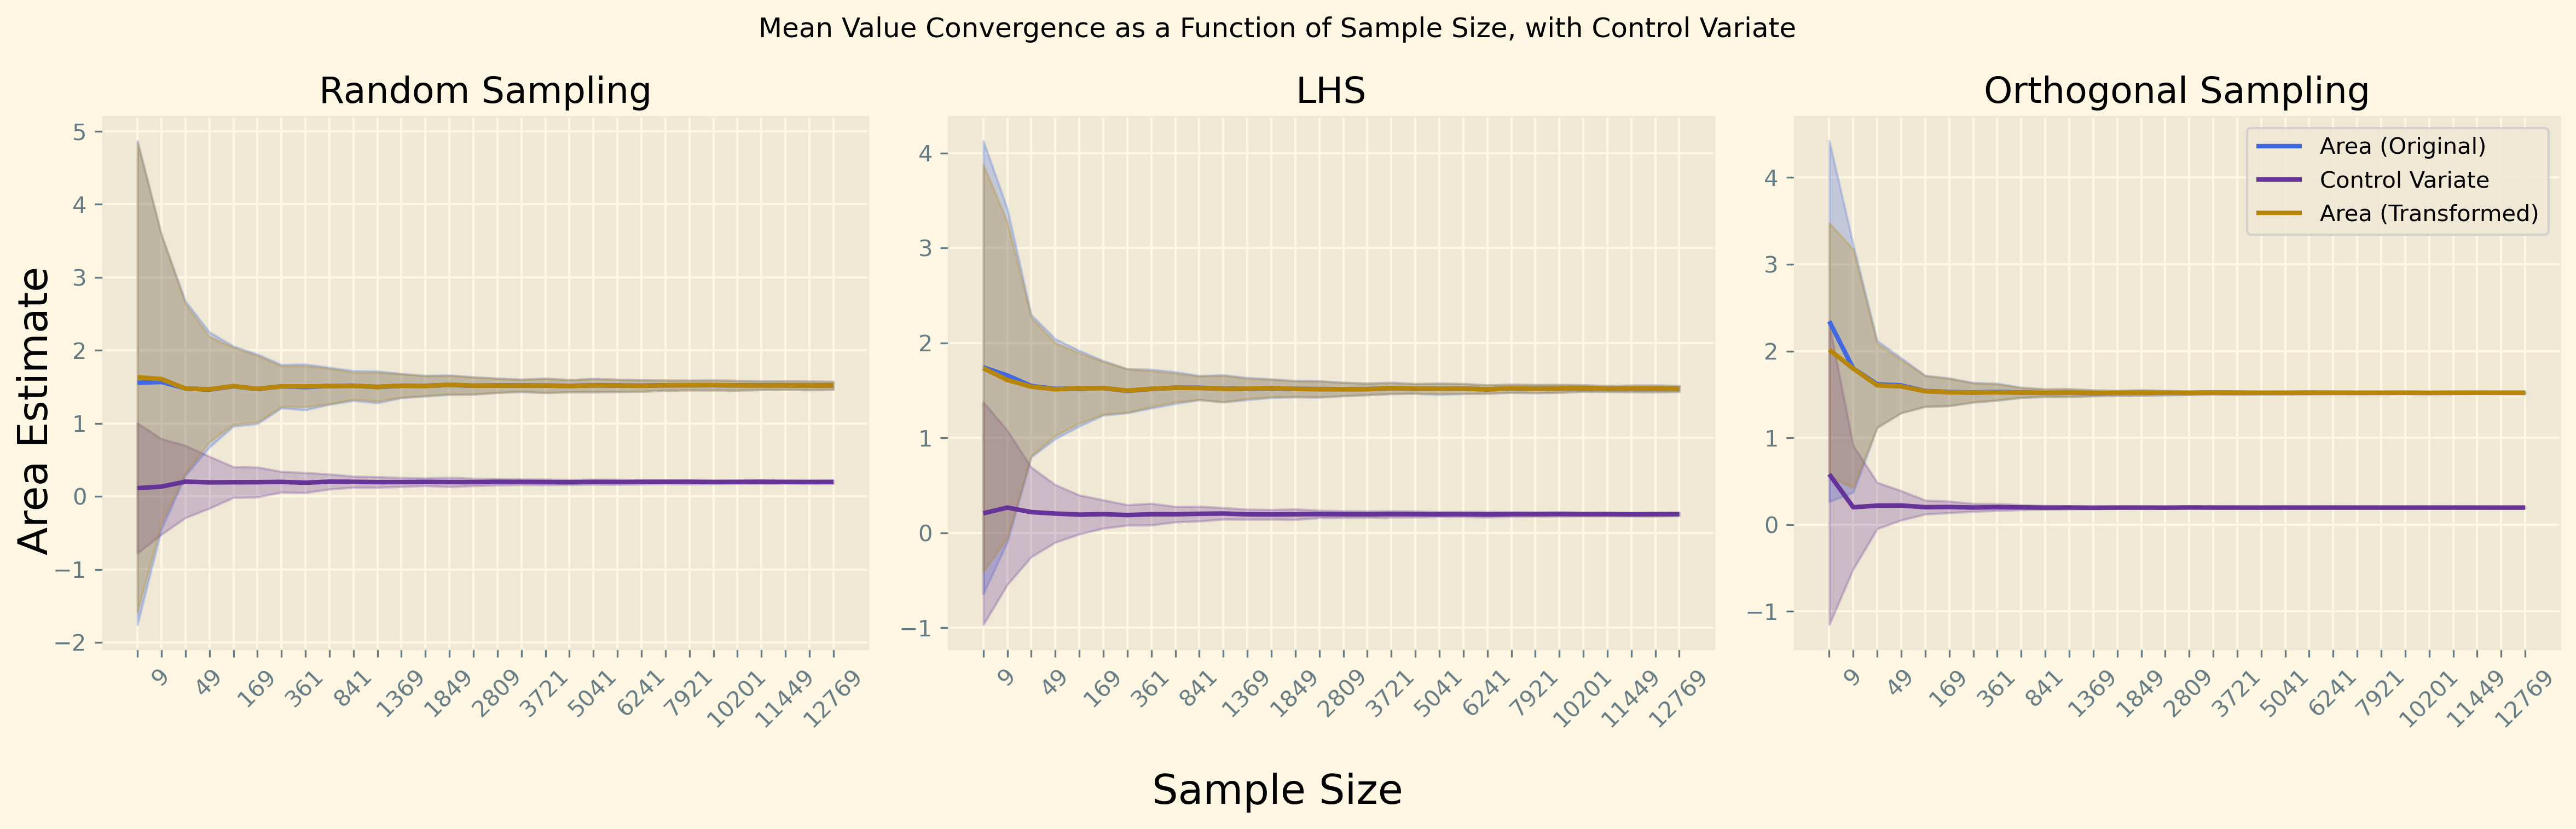

In [314]:
N_s = 120 # HERE_C
num_repeats = 100
max_iter = 300

mean_arr, std_arr, no_densities, density_values = transform_area(x_range,y_range,density=N_s, num_reps=num_repeats, max_iter=max_iter)

## Uncomment this section if GitHub Repo data should be loaded
# mean_arr = np.load("Data/MEANs_Control_Variate_" + str(N_s) + str(num_repeats) + ".npy")
# std_arr = np.load("Data/STDs_Control_Variate_" + str(N_s) + str(num_repeats) + ".npy")

# PLOTTING
upper = np.zeros((no_densities, 9))
lower = np.zeros((no_densities, 9))

x = [str(val) for val in density_values]

for n in range(no_densities):
    upper[n] = mean_arr[n] + 2 * std_arr[n]
    lower[n] = mean_arr[n] - 2 * std_arr[n]


fig = plt.figure(figsize=(16,5), dpi = 300)

for t in range(3):
    plt.subplot(131+t)
    labels = ['Area (Original)', 'Control Variate', 'Area (Transformed)']
    colors = ['royalblue', 'rebeccapurple', 'darkgoldenrod']
    for var in range(3):
        plt.plot(x, mean_arr[:,var+3*t], label=labels[var],color=colors[var])
        plt.fill_between(x,lower[:, var+3*t], upper[:,var+3*t],color=colors[var],alpha=0.25)
    
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation=45)

    # Setting every second x_tick invisible
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    title = ax.set_title(sampling_labels[t], loc='center')

# Structure: mean_X_R, mean_Y_R, mean_T_R, mean_X_LHS, mean_Y_LHS, mean_T_LHS, mean_X_O, mean_Y_O, mean_T_O
print(mean_arr[-1])

fig.suptitle('Mean Value Convergence as a Function of Sample Size, with Control Variate')
fig.supxlabel('Sample Size', fontsize=18)
fig.supylabel('Area Estimate',fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()


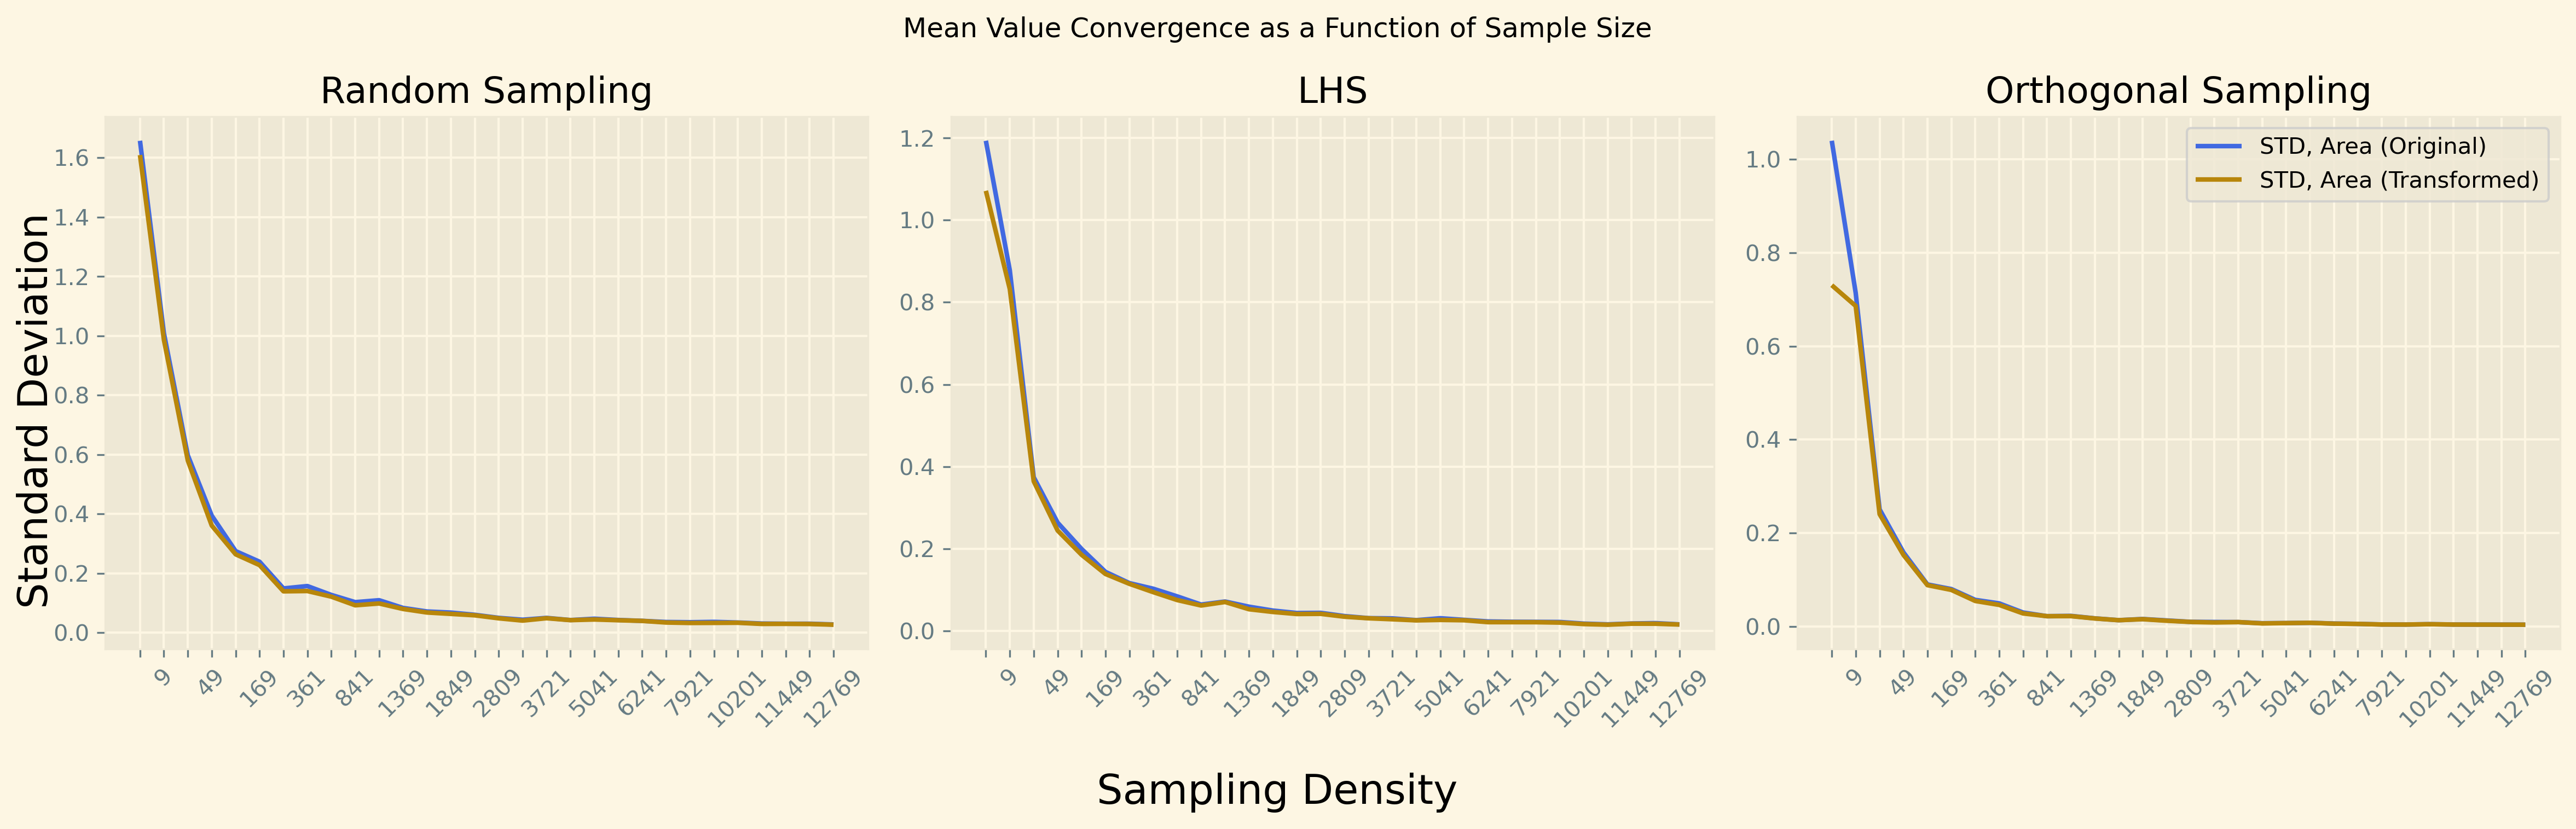

In [315]:
fig = plt.figure(figsize=(16,5), dpi = 300)

for t in range(3):
    plt.subplot(131+t)
    labels = ['STD, Area (Original)', 'Control Variate', 'STD, Area (Transformed)']
    colors = ['royalblue', 'rebeccapurple', 'darkgoldenrod']
    for var in [0,2]:
        plt.plot(x, std_arr[:,var+3*t], label=labels[var],color=colors[var])

    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation=45)

    # Setting every second x_tick invisible
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    title = ax.set_title(sampling_labels[t], loc='center')


fig.suptitle('Mean Value Convergence as a Function of Sample Size')
fig.supxlabel('Sampling Density',fontsize=18)
fig.supylabel('Standard Deviation', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()
